In [ ]:
import numpy as np
import pandas as pd
import os
import datetime
import random as random
from keras import backend as K
import pathlib
import glob
import datetime as dt
from functools import reduce


In [ ]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
def accuracie(y_pred,y_test):
    errors = abs(y_pred - y_test)
    msp=mean_squared_error(y_test, y_pred)
    mape = 100 * (errors / (y_test+0.1))
    accuracy = 100 - np.mean(mape)
    print("MSE: ",msp)
    print('Accuracy:', round(accuracy, 2), '%')

# Visualising the Random Forest Regression results
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_please(y_pred,y_test):
    plt.figure(figsize=(24,10))
    plt.plot(range(len(y_test)), y_test,color = 'red')   
    plt.plot(range(len(y_pred)), y_pred, color = 'cyan',marker='o',linestyle="--") 
    plt.title('Random Forest Regression')
    plt.xlabel('Sample over time')
    plt.ylabel('Load')
    return(plt.show())

def calculate_vif(X_train):   
   # VIF dataframe
   vif_data = pd.DataFrame()
   # calculating VIF for each feature
   vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
   vif_data.index = X_train.columns.values
   return(print(vif_data["VIF"])) 

from sklearn.decomposition import PCA
def apply_pca(df2,x,columns):
     pca = PCA(x)
     X_train = pca.fit_transform(df2)
     df02=pd.DataFrame(X_train,columns=columns)
     return(df02)



In [ ]:
daily_path = "/content/drive/MyDrive/dataset/dailyly.csv"
hourly_path= "/content/drive/MyDrive/dataset/hourly.csv"


In [ ]:
dataset_daily=pd.read_csv(daily_path)
dataset_hourly=pd.read_csv(hourly_path)

In [ ]:
print(dataset_hourly.head(3))
print(dataset_daily.head(3))

               hour  MAC000246  ...  MAC004529  MAC004529clusterH
0  2012-07-02 12:00      0.037  ...      0.068                  0
1  2012-07-02 13:00      0.107  ...      0.147                  0
2  2012-07-02 14:00      0.063  ...      0.137                  0

[3 rows x 63 columns]
   Unnamed: 0  MAC000246  ...  MAC004529  MAC004529cluster
0  2012-07-02      5.640  ...      7.092                 4
1  2012-07-03      6.253  ...      5.605                 1
2  2012-07-04      5.325  ...      4.959                 7

[3 rows x 63 columns]


In [ ]:
dataset_hourly.index=dataset_hourly["hour"]
dataset_hourly.drop("hour",axis=1,inplace=True)
dataset_daily.index=dataset_daily["Unnamed: 0"]
dataset_daily.drop("Unnamed: 0",axis=1,inplace=True)

x=[]
for i in dataset_daily.index:
      for j in dataset_hourly.index:
            if i[:10]==j[:10]:
                x.append(i) 
data=pd.DataFrame()
data.index=x

daily_df=pd.merge(data, dataset_daily, left_index=True, right_index=True)
dummy=set(daily_df.columns.values)
column_retain=set([i for i in dummy if i[-7:]=="cluster" ])
column_drop=list(dummy.difference(column_retain))
daily_df.drop(column_drop,axis=1,inplace=True)
index_count=2
for count in range(len(dataset_hourly.columns.values)//2):
          dataset_hourly.insert(index_count,[daily_df.columns.values][0][count],daily_df.iloc[:,[count]].values)
          index_count=index_count+3



In [ ]:
dataset_hourly.head()

,MAC000246,MAC000246clusterH,MAC000246cluster,MAC004179,MAC004179clusterH,MAC004179cluster,MAC004247,MAC004247clusterH,MAC004247cluster,MAC004319,MAC004319clusterH,MAC004319cluster,MAC004387,MAC004387clusterH,MAC004387cluster,MAC004431,MAC004431clusterH,MAC004431cluster,MAC000323,MAC000323clusterH,MAC000323cluster,MAC000713,MAC000713clusterH,MAC000713cluster,MAC000768,MAC000768clusterH,MAC000768cluster,MAC000778,MAC000778clusterH,MAC000778cluster,MAC000816,MAC000816clusterH,MAC000816cluster,MAC000850,MAC000850clusterH,MAC000850cluster,MAC000886,MAC000886clusterH,MAC000886cluster,MAC000902,...,MAC001528cluster,MAC001628,MAC001628clusterH,MAC001628cluster,MAC001710,MAC001710clusterH,MAC001710cluster,MAC001734,MAC001734clusterH,MAC001734cluster,MAC001893,MAC001893clusterH,MAC001893cluster,MAC001989,MAC001989clusterH,MAC001989cluster,MAC002025,MAC002025clusterH,MAC002025cluster,MAC002150,MAC002150clusterH,MAC002150cluster,MAC002314,MAC002314clusterH,MAC002314cluster,MAC002628,MAC002628clusterH,MAC002628cluster,MAC002937,MAC002937clusterH,MAC002937cluster,MAC003072,MAC003072clusterH,MAC003072cluster,MAC003110,MAC003110clusterH,MAC003110cluster,MAC004529,MAC004529clusterH,MAC004529cluster
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-02 12:00,0.037,0,1,2.400,1,0,0.732,0,0,0.604,1,0,0.056,1,3,0.469,0,0,0.183,0,6,0.240,0,1,0.086,2,6,0.208,0,1,0.133,0,7,0.189,0,3,0.108,0,2,0.615,...,5,0.135,0,0,0.232,1,0,0.836,0,4,0.188,0,0,0.086,0,0,0.071,0,1,1.549,1,1,0.048,0,0,0.438,0,0,0.299459,0,0,0.534,0,3,0.090,0,0,0.068,0,4
2012-07-02 13:00,0.107,0,1,5.115,0,0,1.880,1,0,1.222,1,0,0.095,1,3,1.667,1,0,0.293,0,6,0.510,0,1,0.158,2,6,1.299,0,1,0.180,0,7,0.583,0,3,0.159,0,2,1.216,...,5,0.142,0,0,0.440,1,0,1.465,0,4,0.367,0,0,0.134,0,0,0.183,0,1,1.855,1,1,0.733,0,0,0.695,0,0,0.598919,0,0,1.227,1,3,0.178,0,0,0.147,0,4
2012-07-02 14:00,0.063,0,1,3.473,1,0,1.205,1,0,1.211,1,0,0.100,1,3,1.244,0,0,0.228,0,6,0.505,0,1,0.134,2,6,0.819,0,1,0.176,0,7,0.560,0,3,0.203,0,2,1.608,...,5,0.097,0,0,0.364,1,0,1.434,0,4,1.784,1,0,0.174,0,0,0.182,0,1,0.445,0,1,0.357,0,0,0.759,0,0,0.806459,0,0,1.694,1,3,0.177,0,0,0.137,0,4
2012-07-02 15:00,0.060,0,1,4.644,1,0,0.517,0,0,1.224,1,0,0.113,1,3,0.714,0,0,0.254,0,6,0.592,0,1,0.192,2,6,0.438,0,1,0.176,0,7,0.475,0,3,0.212,0,2,1.362,...,5,0.146,0,0,0.254,1,0,1.475,0,4,0.781,0,0,0.134,0,0,0.135,0,1,0.294,0,1,0.216,0,0,0.678,0,0,0.749000,0,0,1.666,1,3,0.220,0,0,0.146,0,4
2012-07-02 16:00,0.126,0,1,3.516,1,0,1.281,1,0,1.413,1,0,0.100,1,3,1.082,0,0,0.250,0,6,0.585,0,1,0.140,2,6,0.480,0,1,0.229,0,7,0.530,0,3,1.951,1,2,1.685,...,5,0.200,0,0,0.615,1,0,1.374,0,4,0.392,0,0,0.171,0,0,0.167,0,1,0.205,0,1,0.231,0,0,0.760,0,0,0.260000,0,0,1.376,1,3,0.180,0,0,0.141,0,4


In [ ]:
df_dataset=dataset_hourly.iloc[:,45:46]
df1_dataset=df_dataset.copy()
print(df_dataset.shape)
df_dataset.head(4)

(14533, 1)


,MAC000974
hour,
2012-07-02 12:00,0.099
2012-07-02 13:00,0.245
2012-07-02 14:00,0.155
2012-07-02 15:00,0.150


In [ ]:
#n_hourly_sum
def create_SM_features(df_dataset,N):
  list_dummy=[]
  for n in N:               #pass N as list   
     df_n_hourly_sum,df_n_hourly_median,df_n_hourly=0,0,0  
     df_dataset.index=pd.to_datetime(df_dataset.index)
     tisa=str(n)+"H"
     df_n_hourly_sum = df_dataset.resample(tisa).transform('sum')
     df_n_hourly_sum['day'] = [i.day for i in df_n_hourly_sum.index]
     df_n_hourly_sum.index = df_n_hourly_sum.index
     df_n_hourly_sum.drop(["day"],axis=1,inplace=True)
   #n_hourly_median
     df_dataset.index=pd.to_datetime(df_dataset.index)
     df_n_hourly_median = df_dataset.resample(tisa).transform('median')
     df_n_hourly_median['day'] = [i.day for i in df_n_hourly_median.index]
     df_n_hourly_median.index = df_n_hourly_median.index
     df_n_hourly_median.drop(["day"],axis=1,inplace=True)
     suffix_name=["_"+str(n)+"sum","_"+str(n)+"median"]
     df_n_hourly=df_n_hourly_sum.merge(df_n_hourly_median,left_index=True,right_index=True,suffixes=suffix_name)
     list_dummy.append(df_n_hourly)
  df009=pd.concat(list_dummy,axis=1)
  return df009
N=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,36,48,96,132,152,200,250,350,450,530,650,720,800,950,1020,1180,1200,1327,1440]
N=N+list(range(1400, 10000,150))
training_set_dummy=create_SM_features(df_dataset,N)
print("created_features:",len(N)*2)

created_features: 198


In [ ]:
# from sklearn.model_selection import GridSearchCV
# # Number of trees in random forest
# # n_estimators = [100,150,200]
# # Maximum number of levels in tree
# # Minimum number of samples required to split a node
# min_samples_split = [5,10,15,20,50]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [3,5,7,10,15]
# # Create the random grid
# random_grid = {#"n_estimators":n_estimators,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,}
# print(random_grid)
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = GridSearchCV(estimator = rf, param_grid= random_grid, cv = 3, verbose=1, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(training_set.iloc[:1000], target_variable[:1000])
# rf_random.best_params_

In [ ]:
#PCA Without scaling
from sklearn.decomposition import PCA
pca = PCA(0.99)
X_train = pca.fit_transform(training_set_dummy)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data1=scaler.fit_transform(training_set_dummy)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data1=scaler.fit_transform(training_set_dummy)

In [ ]:
pca.explained_variance_ratio_

array([0.76643764, 0.09014693, 0.04568905, 0.02471956, 0.01350683,
       0.00923759, 0.00667601, 0.00609984, 0.00424306, 0.00362357,
       0.00283036, 0.00275933, 0.0023722 , 0.00192401, 0.00174302,
       0.00156975, 0.00149927, 0.00130872, 0.00118147, 0.00104961,
       0.00094903, 0.00090062])

In [ ]:
data=pd.DataFrame(data1,index=training_set_dummy.index.values)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197
2012-07-02 12:00:00,0.080135,0.071101,0.110149,0.106793,0.085255,0.129925,0.264057,0.130845,0.026210,0.144174,0.071420,0.158771,0.214388,0.148926,0.217847,0.172612,0.343627,0.269128,0.430301,0.250838,0.000000,0.150456,0.000000,0.165493,0.000000,0.166951,0.042725,0.183286,0.00000,0.258621,0.175451,0.258427,0.089378,0.228381,0.092838,0.297872,0.167946,0.318907,0.243984,0.377632,...,1.0,0.5,1.0,0.512195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2012-07-02 13:00:00,0.080135,0.071101,0.110149,0.106793,0.085255,0.129925,0.264057,0.130845,0.026210,0.144174,0.071420,0.158771,0.214388,0.148926,0.217847,0.172612,0.343627,0.269128,0.430301,0.250838,0.420818,0.310030,0.000000,0.165493,0.000000,0.166951,0.042725,0.183286,0.00000,0.258621,0.175451,0.258427,0.089378,0.228381,0.092838,0.297872,0.167946,0.318907,0.243984,0.377632,...,1.0,0.5,1.0,0.512195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2012-07-02 14:00:00,0.080135,0.071101,0.110149,0.106793,0.085255,0.129925,0.264057,0.130845,0.355721,0.165130,0.071420,0.158771,0.214388,0.148926,0.217847,0.172612,0.343627,0.269128,0.430301,0.250838,0.420818,0.310030,0.324820,0.171127,0.000000,0.166951,0.042725,0.183286,0.00000,0.258621,0.175451,0.258427,0.089378,0.228381,0.092838,0.297872,0.167946,0.318907,0.243984,0.377632,...,1.0,0.5,1.0,0.512195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2012-07-02 15:00:00,0.233660,0.068807,0.110149,0.106793,0.317102,0.165130,0.264057,0.130845,0.355721,0.165130,0.071420,0.158771,0.214388,0.148926,0.217847,0.172612,0.343627,0.269128,0.430301,0.250838,0.420818,0.310030,0.324820,0.171127,0.292805,0.158433,0.042725,0.183286,0.00000,0.258621,0.175451,0.258427,0.089378,0.228381,0.092838,0.297872,0.167946,0.318907,0.243984,0.377632,...,1.0,0.5,1.0,0.512195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2012-07-02 16:00:00,0.233660,0.068807,0.289545,0.140406,0.317102,0.165130,0.264057,0.130845,0.355721,0.165130,0.407585,0.274336,0.214388,0.148926,0.217847,0.172612,0.343627,0.269128,0.430301,0.250838,0.420818,0.310030,0.324820,0.171127,0.292805,0.158433,0.294330,0.076923,0.00000,0.258621,0.175451,0.258427,0.089378,0.228381,0.092838,0.297872,0.167946,0.318907,0.243984,0.377632,...,1.0,0.5,1.0,0.512195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,0.348482,0.395872,0.255601,0.257003,0.285153,0.301760,0.444537,0.341484,0.301915,0.307628,0.426845,0.382093,0.436797,0.351562,0.133177,0.384350,0.420362,0.373154,0.471750,0.350838,0.440042,0.531915,0.402938,0.314789,0.321882,0.507666,0.473670,0.411206,0.28291,0.612069,0.557994,0.451481,0.267254,0.671840,0.029278,0.758448,0.284223,0.503417,0.514574,0.375000,...,0.0,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2014-02-27 21:00:00,0.174081,0.165138,0.255601,0.257003,0.285153,0.301760,0.444537,0.341484,0.301915,0.307628

In [ ]:
df_dataset

,MAC000974
hour,
2012-07-02 12:00:00,0.099
2012-07-02 13:00:00,0.245
2012-07-02 14:00:00,0.155
2012-07-02 15:00:00,0.150
2012-07-02 16:00:00,0.141
...,...
2014-02-27 20:00:00,0.422
2014-02-27 21:00:00,0.374
2014-02-27 22:00:00,0.350


In [ ]:
target_variable=df_dataset
training_set=data
regressor = RandomForestRegressor(n_estimators = 300,oob_score=True ,min_samples_leaf=15,min_samples_split=25,random_state = 0)
# fit the regressor with x and y data
regressor.fit(training_set, target_variable)
train_pred=regressor.oob_prediction_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


scoring on Test Dataset
MSE:  0.027625204015559634
Accuracy: MAC000974    75.79
dtype: float64 %


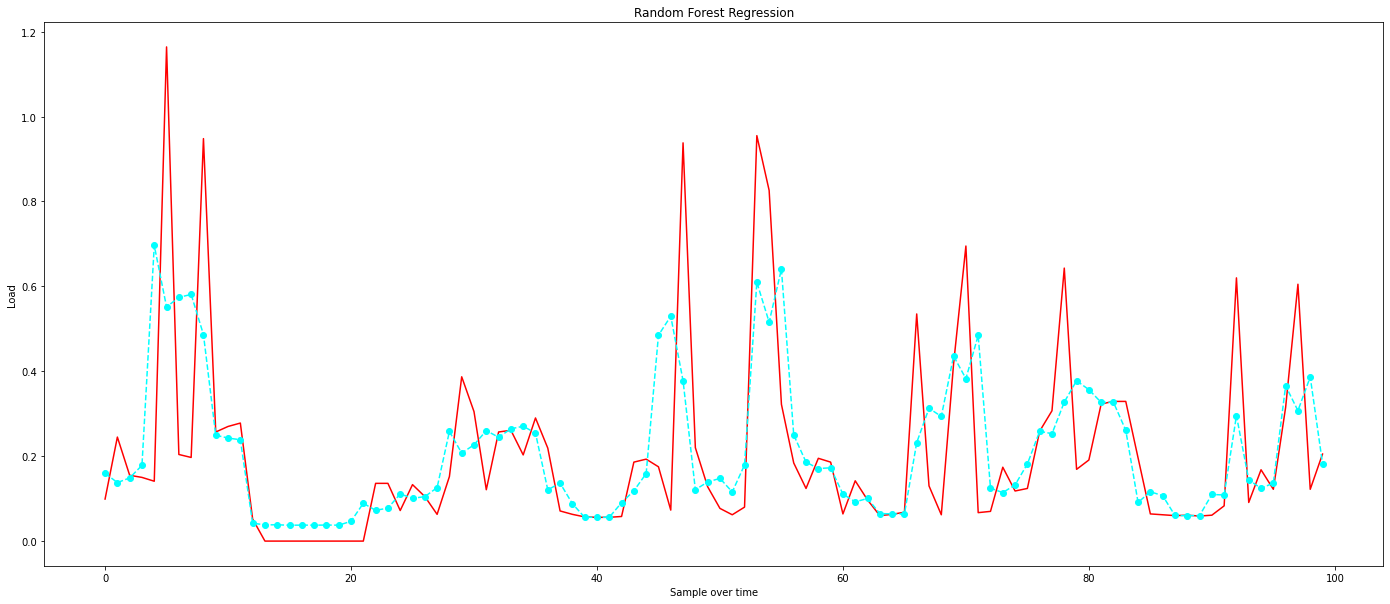

In [ ]:
print("scoring on Test Dataset")
accuracie(train_pred.reshape(-1,1),target_variable)
plot_please(train_pred[:100],target_variable[:100])

In [ ]:
from pandas import DataFrame
from pandas import concat
#Function to generate forecasting data
#n_in=1 ,for n>1 just manage the loop's   
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 
        df = DataFrame(data)
        cols, names = [],[] 
        # input sequence (t-n, ... t-1)
        for i in range(n_in,0,-1):
                cols.append(df.shift(i))
                names.append(str('var0'))       #names.append([lambda x:'var%d(t-%d)'%(x+1, i)) range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                names.append("var"+str(i+1))
        #print(names)
        agg = concat(cols, axis=1)
        agg.columns=names 
        # drop rows with NaN values
        if dropnan:
           agg.dropna(inplace=True)
        return agg
valus = df_dataset.MAC000974.values
n_past=100
data_lag = series_to_supervised(valus, 1,n_past,dropnan=True)
data_lag.index=df_dataset.index.values[:-int(n_past)]

In [ ]:
data_lag.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90,var91,var92,var93,var94,var95,var96,var97,var98,var99,var100
2012-07-02 12:00:00,0.099,0.245,0.155,0.150,0.141,1.164,0.204,0.197,0.948,0.257,0.270,0.278,0.052,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.136,0.136,0.072,0.133,0.105,0.063,0.152,0.387,0.305,0.121,0.257,0.261,0.203,0.290,0.219,0.071,0.063,0.057,...,0.142,0.097,0.060,0.063,0.068,0.535,0.130,0.062,0.418,0.695,0.067,0.070,0.174,0.118,0.124,0.259,0.307,0.643,0.169,0.191,0.323,0.329,0.329,0.196,0.064,0.062,0.060,0.061,0.059,0.061,0.083,0.620,0.091,0.168,0.122,0.315,0.605,0.122,0.205,0.112
2012-07-02 13:00:00,0.245,0.155,0.150,0.141,1.164,0.204,0.197,0.948,0.257,0.270,0.278,0.052,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.136,0.136,0.072,0.133,0.105,0.063,0.152,0.387,0.305,0.121,0.257,0.261,0.203,0.290,0.219,0.071,0.063,0.057,0.056,...,0.097,0.060,0.063,0.068,0.535,0.130,0.062,0.418,0.695,0.067,0.070,0.174,0.118,0.124,0.259,0.307,0.643,0.169,0.191,0.323,0.329,0.329,0.196,0.064,0.062,0.060,0.061,0.059,0.061,0.083,0.620,0.091,0.168,0.122,0.315,0.605,0.122,0.205,0.112,0.225
2012-07-02 14:00:00,0.155,0.150,0.141,1.164,0.204,0.197,0.948,0.257,0.270,0.278,0.052,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.136,0.136,0.072,0.133,0.105,0.063,0.152,0.387,0.305,0.121,0.257,0.261,0.203,0.290,0.219,0.071,0.063,0.057,0.056,0.056,...,0.060,0.063,0.068,0.535,0.130,0.062,0.418,0.695,0.067,0.070,0.174,0.118,0.124,0.259,0.307,0.643,0.169,0.191,0.323,0.329,0.329,0.196,0.064,0.062,0.060,0.061,0.059,0.061,0.083,0.620,0.091,0.168,0.122,0.315,0.605,0.122,0.205,0.112,0.225,0.852
2012-07-02 15:00:00,0.150,0.141,1.164,0.204,0.197,0.948,0.257,0.270,0.278,0.052,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.136,0.136,0.072,0.133,0.105,0.063,0.152,0.387,0.305,0.121,0.257,0.261,0.203,0.290,0.219,0.071,0.063,0.057,0.056,0.056,0.058,...,0.063,0.068,0.535,0.130,0.062,0.418,0.695,0.067,0.070,0.174,0.118,0.124,0.259,0.307,0.643,0.169,0.191,0.323,0.329,0.329,0.196,0.064,0.062,0.060,0.061,0.059,0.061,0.083,0.620,0.091,0.168,0.122,0.315,0.605,0.122,0.205,0.112,0.225,0.852,0.265
2012-07-02 16:00:00,0.141,1.164,0.204,0.197,0.948,0.257,0.270,0.278,0.052,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.136,0.136,0.072,0.133,0.105,0.063,0.152,0.387,0.305,0.121,0.257,0.261,0.203,0.290,0.219,0.071,0.063,0.057,0.056,0.056,0.058,0.186,...,0.068,0.535,0.130,0.062,0.418,0.695,0.067,0.070,0.174,0.118,0.124,0.259,0.307,0.643,0.169,0.191,0.323,0.329,0.329,0.196,0.064,0.062,0.060,0.061,0.059,0.061,0.083,0.620,0.091,0.168,0.122,0.315,0.605,0.122,0.205,0.112,0.225,0.852,0.265,0.177


In [ ]:
final_df=data_lag.merge(data.iloc[n_past:,:],right_index=True,left_index=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14333 entries, 2012-07-06 16:00:00 to 2014-02-23 20:00:00
Columns: 299 entries, var0 to 197
dtypes: float64(299)
memory usage: 32.8 MB


In [ ]:
target_variable=final_df["var100"]
training_set=final_df.drop(["var100"],axis=1)
regressor = RandomForestRegressor(n_estimators = 200,oob_score=True ,min_samples_leaf=15,min_samples_split=25,random_state = 0)
# fit the regressor with x and y data
regressor.fit(training_set, target_variable)
train_pred=regressor.oob_prediction_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


scoring on Test Dataset
MSE:  0.0412044319499286
Accuracy: 70.07 %


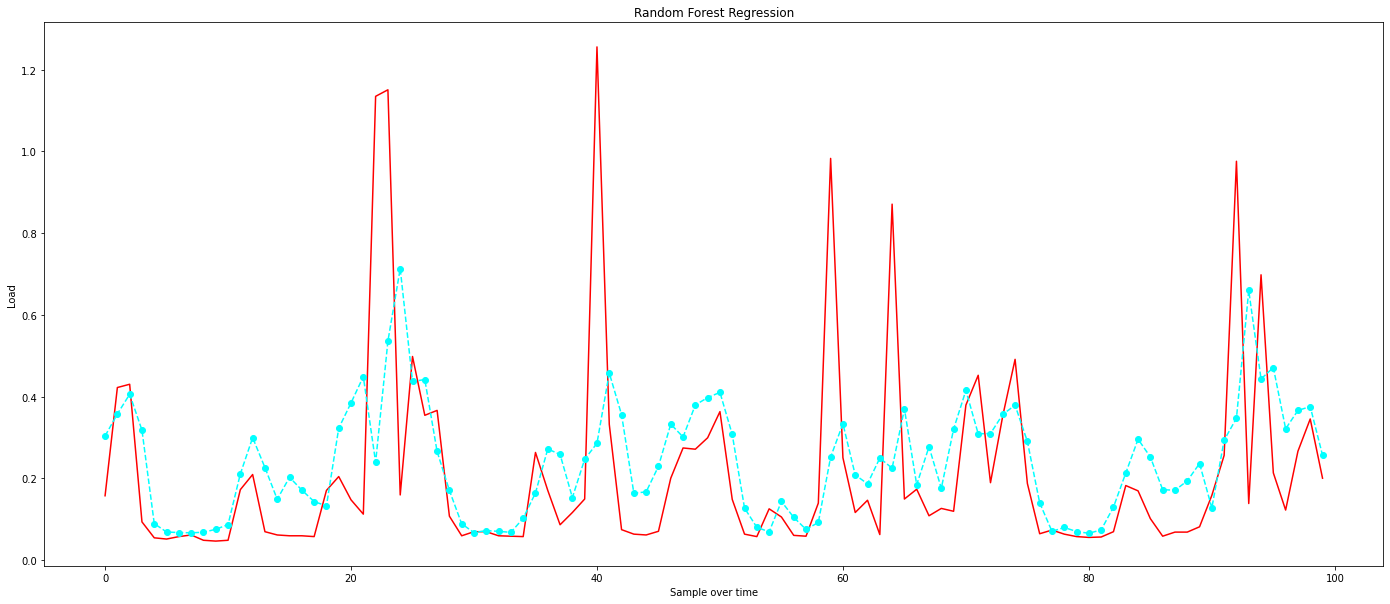

In [ ]:
print("scoring on Test Dataset")
accuracie(train_pred,target_variable)
plot_please(train_pred[:100],target_variable[:100])

In [ ]:
N=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,36,48,96,132,152,200,250,350,450,530,650,720,800,950,1020,1180,1200,1327,1440]
training_set_dummy=create_SM_features(df_dataset,N)
print("created_features:",len(N)*2)

created_features: 82


In [ ]:
scaler = MinMaxScaler()
# data1=scaler.fit_transform(training_set_dummy)

In [ ]:
target_variable=df_dataset
training_set=training_set_dummy
regressor = RandomForestRegressor(n_estimators = 250,oob_score=True ,min_samples_leaf=15,min_samples_split=25,random_state = 0)
# fit the regressor with x and y data
regressor.fit(training_set, target_variable)
train_pred=regressor.oob_prediction_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


scoring on Test Dataset
MSE:  0.027613202931923923
Accuracy: MAC000974    75.8
dtype: float64 %


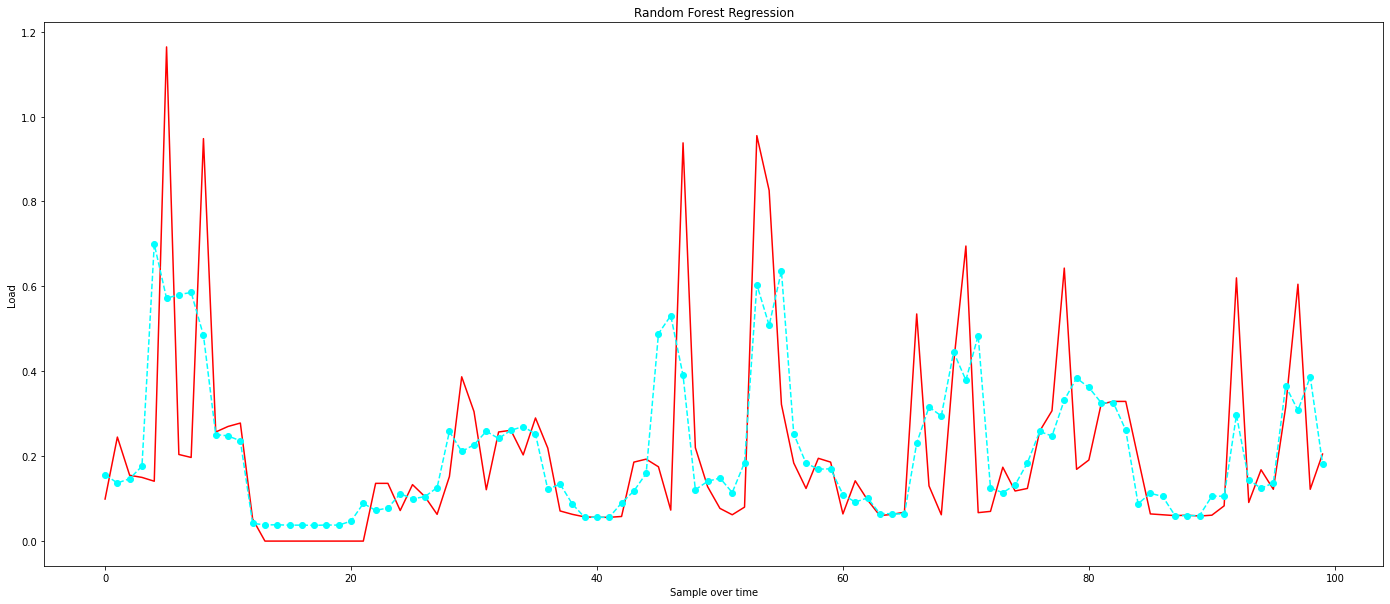

In [ ]:
print("scoring on Test Dataset")
accuracie(train_pred.reshape(-1,1),target_variable)
plot_please(train_pred[:100],target_variable[:100])

In [ ]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [100,150,200,300]
# Maximum number of levels in tree
# Minimum number of samples required to split a node
min_samples_split = [5,10,15,20,50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3,5,7,10,15,25]
# Create the random grid
random_grid = {"n_estimators":n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid= random_grid, cv = 5, verbose=1, n_jobs = -1)
# Fit the random search model
cv_results=rf_random.fit(training_set.iloc[:500], target_variable[:500])


{'n_estimators': [100, 150, 200, 300], 'min_samples_split': [5, 10, 15, 20, 50], 'min_samples_leaf': [3, 5, 7, 10, 15, 25]}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'min_samples_leaf': 3, 'min_samples_split': 20, 'n_estimators': 300}

In [ ]:
rf_random.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 20, 'n_estimators': 300}

In [ ]:
target_variable=df_dataset
training_set=training_set_dummy
regressor = RandomForestRegressor(n_estimators = 250,oob_score=True ,min_samples_leaf=15,min_samples_split=20,random_state = 0)
# fit the regressor with x and y data
regressor.fit(training_set, target_variable)
train_pred=regressor.oob_prediction_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


scoring on Test Dataset
MSE:  0.027613202931923923
Accuracy: MAC000974    75.8
dtype: float64 %


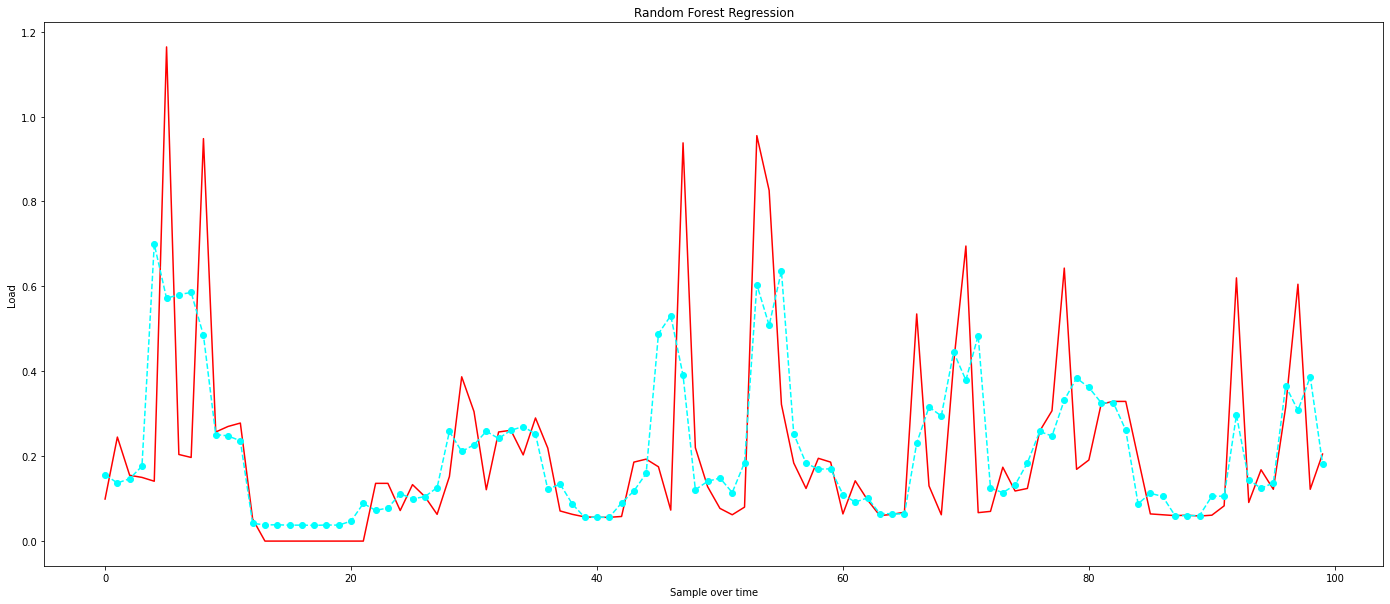

In [ ]:
print("scoring on Test Dataset")
accuracie(train_pred.reshape(-1,1),target_variable)
plot_please(train_pred[:100],target_variable[:100])

In [ ]:
#n_hourly_sum
def create_SM_features(df_dataset,N):
  list_dummy=[]
  for n in N:               #pass N as list
     df_n_hourly_sum,df_n_hourly_median,df_n_hourly=0,0,0
     df_dataset.index=pd.to_datetime(df_dataset.index)
     tisa=str(n)+"H"
    #n_hourly_sum
     df_n_hourly_sum = df_dataset.resample(tisa).transform('sum')
     df_n_hourly_sum['day'] = [i.day for i in df_n_hourly_sum.index]
     df_n_hourly_sum.index = df_n_hourly_sum.index
     df_n_hourly_sum.drop(["day"],axis=1,inplace=True)
     df_n_hourly_sum.columns=[tisa+"sum"]
   #n_hourly_max
     df_n_hourly_max = df_dataset.resample(tisa).transform('max')
     df_n_hourly_max['day'] = [i.day for i in df_n_hourly_max.index]
     df_n_hourly_max.index = df_n_hourly_max.index
     df_n_hourly_max.drop(["day"],axis=1,inplace=True)
     df_n_hourly_max.columns=[tisa+"max"]
    #n_hourly_stdDev
     df_n_hourly_std = df_dataset.resample(tisa).transform(np.std)
     df_n_hourly_std['day'] = [i.day for i in df_n_hourly_std.index]
     df_n_hourly_std.index = df_n_hourly_std.index
     df_n_hourly_std.drop(["day"],axis=1,inplace=True)
     df_n_hourly_std.columns=[tisa+"std"]
   #n_hourly_median
     df_dataset.index=pd.to_datetime(df_dataset.index)
     df_n_hourly_median = df_dataset.resample(tisa).transform('median')
     df_n_hourly_median['day'] = [i.day for i in df_n_hourly_median.index]
     df_n_hourly_median.index = df_n_hourly_median.index
     df_n_hourly_median.drop(["day"],axis=1,inplace=True)
     df_n_hourly_median.columns=[tisa+"median"]
     list_df=[df_n_hourly_sum,df_n_hourly_median,df_n_hourly_max,df_n_hourly_std]
     df_n_hourly=pd.concat(list_df,axis=1)
     list_dummy.append(df_n_hourly)
  df009=pd.concat(list_dummy,axis=1)
  return df009
N=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,36,48,96,132,152,200,250,350,450,530,650,720,800,950,1020,1180,1200,1327,1440,1600,1800,2000,2100,2500,2800]
training_set_dummy=create_SM_features(df_dataset,N)
print("created_features:",len(N)*3)

created_features: 126


In [ ]:
training_set_dummy=training_set_dummy.fillna(0)
training_set_dummy

,2Hsum,2Hmedian,2Hmax,2Hstd,3Hsum,3Hmedian,3Hmax,3Hstd,4Hsum,4Hmedian,4Hmax,4Hstd,5Hsum,5Hmedian,5Hmax,5Hstd,6Hsum,6Hmedian,6Hmax,6Hstd,7Hsum,7Hmedian,7Hmax,7Hstd,8Hsum,8Hmedian,8Hmax,8Hstd,9Hsum,9Hmedian,9Hmax,9Hstd,10Hsum,10Hmedian,10Hmax,10Hstd,11Hsum,11Hmedian,11Hmax,11Hstd,...,530Hsum,530Hmedian,530Hmax,530Hstd,650Hsum,650Hmedian,650Hmax,650Hstd,720Hsum,720Hmedian,720Hmax,720Hstd,800Hsum,800Hmedian,800Hmax,800Hstd,950Hsum,950Hmedian,950Hmax,950Hstd,1020Hsum,1020Hmedian,1020Hmax,1020Hstd,1180Hsum,1180Hmedian,1180Hmax,1180Hstd,1200Hsum,1200Hmedian,1200Hmax,1200Hstd,1327Hsum,1327Hmedian,1327Hmax,1327Hstd,1440Hsum,1440Hmedian,1440Hmax,1440Hstd
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-02 12:00:00,0.344,0.1720,0.245,0.103238,0.499,0.155,0.245,0.073657,0.649,0.1525,0.245,0.060693,0.499,0.155,0.245,0.073657,1.954,0.1525,1.164,0.413467,0.344,0.172,0.245,0.103238,0.649,0.1525,0.245,0.060693,1.954,0.1525,1.164,0.413467,2.355,0.176,1.164,0.354219,3.560,0.2005,1.164,0.375492,...,105.197,0.115,1.379,0.242956,135.862,0.1205,2.062,0.254972,148.416,0.1205,2.062,0.248282,165.185,0.1215,2.062,0.244867,198.530,0.122,2.062,0.244078,213.690,0.123,2.062,0.241999,259.761,0.1285,2.062,0.249862,265.873,0.13,2.062,0.251006,309.144000,0.131,2.803,0.273316,343.085,0.132,2.803,0.278892
2012-07-02 13:00:00,0.344,0.1720,0.245,0.103238,0.499,0.155,0.245,0.073657,0.649,0.1525,0.245,0.060693,0.499,0.155,0.245,0.073657,1.954,0.1525,1.164,0.413467,0.344,0.172,0.245,0.103238,0.649,0.1525,0.245,0.060693,1.954,0.1525,1.164,0.413467,2.355,0.176,1.164,0.354219,3.560,0.2005,1.164,0.375492,...,105.197,0.115,1.379,0.242956,135.862,0.1205,2.062,0.254972,148.416,0.1205,2.062,0.248282,165.185,0.1215,2.062,0.244867,198.530,0.122,2.062,0.244078,213.690,0.123,2.062,0.241999,259.761,0.1285,2.062,0.249862,265.873,0.13,2.062,0.251006,309.144000,0.131,2.803,0.273316,343.085,0.132,2.803,0.278892
2012-07-02 14:00:00,0.305,0.1525,0.155,0.003536,0.499,0.155,0.245,0.073657,0.649,0.1525,0.245,0.060693,0.499,0.155,0.245,0.073657,1.954,0.1525,1.164,0.413467,2.959,0.197,1.164,0.437725,0.649,0.1525,0.245,0.060693,1.954,0.1525,1.164,0.413467,2.355,0.176,1.164,0.354219,3.560,0.2005,1.164,0.375492,...,105.197,0.115,1.379,0.242956,135.862,0.1205,2.062,0.254972,148.416,0.1205,2.062,0.248282,165.185,0.1215,2.062,0.244867,198.530,0.122,2.062,0.244078,213.690,0.123,2.062,0.241999,259.761,0.1285,2.062,0.249862,265.873,0.13,2.062,0.251006,309.144000,0.131,2.803,0.273316,343.085,0.132,2.803,0.278892
2012-07-02 15:00:00,0.305,0.1525,0.155,0.003536,1.455,0.150,1.164,0.588048,0.649,0.1525,0.245,0.060693,1.856,0.197,1.164,0.444059,1.954,0.1525,1.164,0.413467,2.959,0.197,1.164,0.437725,0.649,0.1525,0.245,0.060693,1.954,0.1525,1.164,0.413467,2.355,0.176,1.164,0.354219,3.560,0.2005,1.164,0.375492,...,105.197,0.115,1.379,0.242956,135.862,0.1205,2.062,0.254972,148.416,0.1205,2.062,0.248282,165.185,0.1215,2.062,0.244867,198.530,0.122,2.062,0.244078,213.690,0.123,2.062,0.241999,259.761,0.1285,2.062,0.249862,265.873,0.13,2.062,0.251006,309.144000,0.131,2.803,0.273316,343.085,0.132,2.803,0.278892
2012-07-02 16:00:00,1.305,0.6525,1.164,0.723370,1.455,0.150,1.164,0.588048,1.706,0.2005,1.164,0.492474,1.856,0.197,1.164,0.444059,1.954,0.1525,1.164,0.413467,2.959,0.197,1.164,0.437725,3.459,0.2635,1.164,0.391801,1.954,0.1525,1.164,0.413467,2.355,0.176,1.164,0.354219,3.560,0.2005,1.164,0.375492,...,105.197,0.115,1.379,0.242956,135.862,0.1205,2.062,0.254972,148.416,0.1205,2.062,0.248282,165.185,0.1215,2.062,0.244867,198.530,0.122,2.062,0.244078,213.690,0.123,2.062,0.241999,259.761,0.1285,2.062,0.249862,265.873,0.13,2.062,0.251006,309.144000,0.131,2.803,0.273316,343.085,0.132,2.803,0.278892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


scoring on Test Dataset
MSE:  0.020304762121193677
Accuracy: MAC000974    81.32
dtype: float64 %


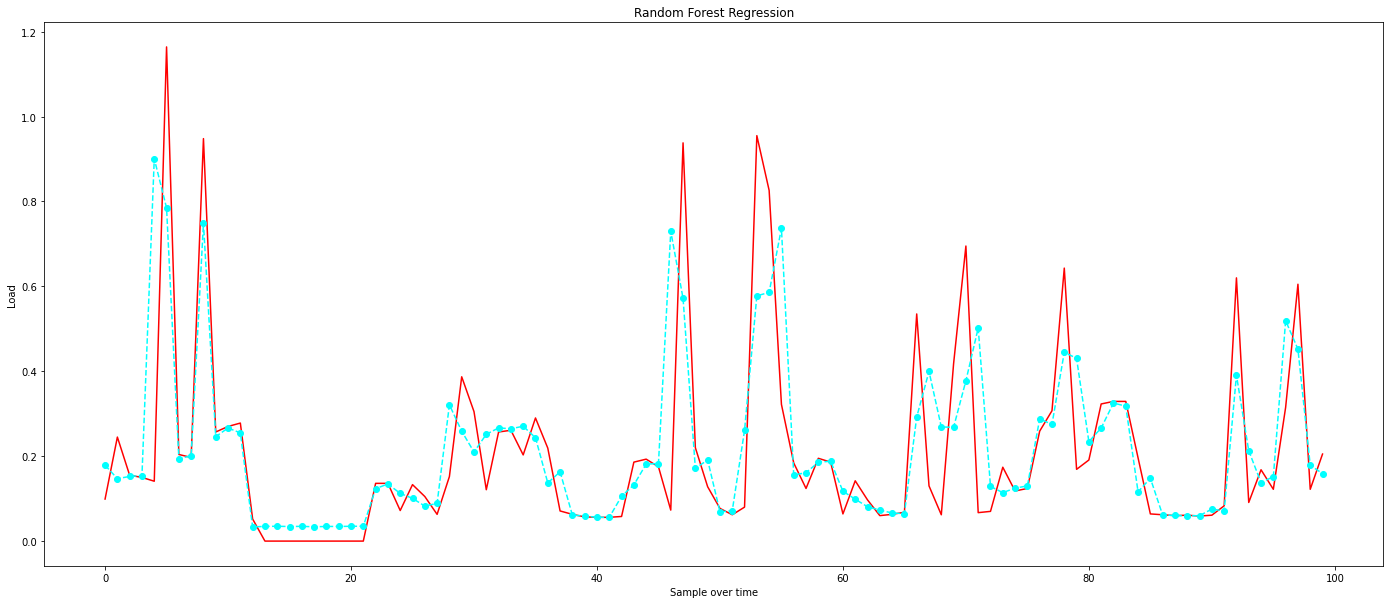

In [ ]:
target_variable=df_dataset
training_set=training_set_dummy
regressor = RandomForestRegressor(n_estimators = 250,oob_score=True ,min_samples_leaf=15,min_samples_split=20,random_state = 0)
# fit the regressor with x and y data
regressor.fit(training_set, target_variable)
train_pred=regressor.oob_prediction_
print("scoring on Test Dataset")
accuracie(train_pred.reshape(-1,1),target_variable)
plot_please(train_pred[:100],target_variable[:100])